# cifar-10 cnn

## imports

In [78]:
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

## data

In [2]:
def unpickle(file):
    with open(file, "rb") as f:
        data_map = pickle.load(f, encoding="bytes")
    return data_map

In [3]:
data = unpickle("../my_datasets/cifar-10-batches-py/data_batch_1")

In [4]:
#10000 images, 1024 pixels (and 3 color channels, 1024 * 3)
data[b"data"].shape

(10000, 3072)

In [5]:
type(data[b"data"])

numpy.ndarray

In [6]:
num_images = data[b"data"].shape[0]
num_pixels = int(data[b"data"].shape[1] / 3)
num_colors = 3
img_dim = [int(num_pixels ** .5)] * 2
print("images: {}\ndimensions: {}\npixels: {}\ncolors: {}".format(
    num_images, img_dim, num_pixels, num_colors
))

images: 10000
dimensions: [32, 32]
pixels: 1024
colors: 3


### reshaping the data
We'll start by reshaping the 2nd dimension of each image to be of shape (3, 1024), where all red features are (0, ?), all green are (1, ?) and all blue are (2, ?). The shape of the entire dataset should afterwards be (10000, 1024, 3).

In [107]:
features = np.asarray(
    list(
        map(
            lambda img: [
                [img[i], img[num_pixels + i], img[2*num_pixels + i]] for i in range(num_pixels)
            ],
            data[b"data"]
        )
    )
)
#).reshape(num_images, img_dim[0], img_dim[1], num_colors)

In [116]:
features.shape

(10000, 1024, 3)

In [14]:
#plt.imshow(reshaped_data[9])

We'll flatten the image so it can be input into the NN and then reshaped inside there.

In [121]:
features_flat = np.array(
    list(
        map(
            lambda img: img.flatten(),
            features
        )
    )
)
features_flat.shape

(10000, 3072)

## labels
Below we'll one-hot encode the labels.

In [30]:
labels = np.asarray(data[b"labels"])
num_classes = np.unique(labels).shape[0]
num_classes

10

In [31]:
labels.shape

(10000,)

In [79]:
#one-hot encoding
labels_ohe = OneHotEncoder().fit_transform(labels.reshape(-1, 1)).toarray()
labels_ohe[:5]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

## splitting the data
Here we'll split the data into training and testing sets.

In [122]:
test_ratio = 0.2
random_seed = 0
x_train, x_test, y_train, y_test = train_test_split(
    features_flat,
    labels_ohe,
    test_size=test_ratio,
    random_state=random_seed
)

## network setup
Below we'll setup the network. We'll create a 2 layer convolution (each with a max pooling layer) connected to 2 dense layers. This model is based on the TensorFlow [CNN tutorial](https://www.tensorflow.org/tutorials/layers).

placeholders

In [83]:
x = tf.placeholder(dtype=tf.float32, shape=[None, num_pixels * num_colors])
y_true = tf.placeholder(dtype=tf.float32, shape=[None, num_classes])

input layer

In [84]:
input_layer = tf.reshape(x, [-1, img_dim[0], img_dim[1], num_colors])

### convolution parameters

In [155]:
#convolution
filters = [32, 64, 128]
kernel_sizes = [[5, 5], [5, 5], [5, 5]]
paddings = ["same"]*3
activations = [tf.nn.relu]*3

#pooling
pool_sizes = [[2, 2], [2, 2], [2, 2]]
strides = [2, 2, 2]

convolution 0

In [156]:
#convolution
conv0 = tf.layers.conv2d(
    inputs=input_layer,
    filters=filters[0],
    kernel_size=kernel_sizes[0],
    padding=paddings[0],
    activation=activations[0]
)
#pool
pool0 = tf.layers.max_pooling2d(
    inputs=conv0,
    pool_size=pool_sizes[0],
    strides=strides[0]
)

convolution 1

Notice that with this structure, the convolutional portion of the network is easily refactorable into a loop.

In [157]:
#convolution
conv1 = tf.layers.conv2d(
    inputs=pool0,
    filters=filters[1],
    kernel_size=kernel_sizes[1],
    padding=paddings[1],
    activation=activations[1]
)
#pool
pool1 = tf.layers.max_pooling2d(
    inputs=conv1,
    pool_size=pool_sizes[1],
    strides=strides[1]
)

convolution 2

In [158]:
#convolution
conv2 = tf.layers.conv2d(
    inputs=pool1,
    filters=filters[2],
    kernel_size=kernel_sizes[2],
    padding=paddings[2],
    activation=activations[2]
)
#pool
pool2 = tf.layers.max_pooling2d(
    inputs=conv2,
    pool_size=pool_sizes[2],
    strides=strides[2]
)

flatten

In [159]:
resulting_img_dim = img_dim[:]
for p in pool_sizes:
    for j in range(2):
        resulting_img_dim[j] = int(resulting_img_dim[j] / p[j])
resulting_img_dim

[4, 4]

In [161]:
# conv_flat = tf.reshape(tensor=pool1, shape=[-1, resulting_img_dim[0] * resulting_img_dim[1] * filters[-1]])
conv_flat = tf.reshape(tensor=pool2, shape=[-1, resulting_img_dim[0] * resulting_img_dim[1] * filters[-1]])

dense 0

In [162]:
#seems like units choice is open to interpretation
drop_rate = tf.placeholder(tf.float32, shape=None)
dense0 = tf.layers.dense(inputs=conv_flat, units=1024, activation=tf.nn.relu)
dropout0 = tf.layers.dropout(inputs=dense0, rate=drop_rate)

logits (y probabilities)

In [163]:
logits = tf.layers.dense(inputs=dropout0, units=num_classes)

### loss

In [164]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
    labels=y_true,
    logits=logits
))

## hyperparams

In [171]:
learning_rate = 0.001
num_epochs = 1000
batch_size = 16
dropout_prob_train = 0.5
dropout_prob_test = 1.0
epochs_between_output = 20

## optimizer

In [172]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(loss)

## batching
This batching function has been copy and pasted from `./cifar10_softmax_nn`.

In [167]:
def get_batches(x, y, batch_size, replacement=True):
    #if batch elements can be copies of one another (duplicates, triplicates, etc.)
    batch_x = []
    batch_y = []
    if replacement:
        indices = np.random.randint(low=0, high=len(x), size=batch_size)
    else:
        indices = [i for i in range(len(x))]
        np.random.shuffle(indices)
        indices = indices[:batch_size]
    for i in indices:
        batch_x.append(x[i])
        batch_y.append(y[i])
    return batch_x, batch_y

## session

In [173]:
init = tf.global_variables_initializer()

In [174]:
accuracies = []

step: 0
acc: 0.09300000220537186
step: 20
acc: 0.15700000524520874
step: 40
acc: 0.21449999511241913
step: 60
acc: 0.2644999921321869
step: 80
acc: 0.24400000274181366
step: 100
acc: 0.3019999861717224
step: 120
acc: 0.25450000166893005
step: 140
acc: 0.28450000286102295
step: 160
acc: 0.31349998712539673
step: 180
acc: 0.29750001430511475
step: 200
acc: 0.3125
step: 220
acc: 0.3630000054836273
step: 240
acc: 0.35249999165534973
step: 260
acc: 0.37049999833106995
step: 280
acc: 0.38499999046325684
step: 300
acc: 0.3504999876022339
step: 320
acc: 0.3930000066757202
step: 340
acc: 0.3569999933242798
step: 360
acc: 0.3695000112056732
step: 380
acc: 0.3935000002384186
step: 400
acc: 0.2874999940395355
step: 420
acc: 0.33899998664855957
step: 440
acc: 0.3370000123977661
step: 460
acc: 0.36149999499320984
step: 480
acc: 0.3644999861717224
step: 500
acc: 0.3815000057220459
step: 520
acc: 0.42100000381469727
step: 540
acc: 0.3930000066757202
step: 560
acc: 0.40799999237060547
step: 580
acc: 0.

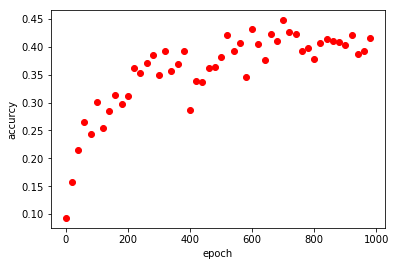

In [175]:
with tf.Session() as sess:
    sess.run(init)
    
    #train
    for i in range(num_epochs):
        batch_x, batch_y = get_batches(x=x_train, y=y_train, batch_size=batch_size, replacement=False)
        sess.run(train, feed_dict={
            x: batch_x,
            y_true: batch_y,
            drop_rate: dropout_prob_train
        })
        
        #progress output
        if i % epochs_between_output == 0:
            print("step: {}".format(i))
            matches = tf.equal(tf.argmax(y_true, 1), tf.argmax(logits, 1))
            acc_op = tf.reduce_mean(tf.cast(matches, dtype=tf.float32))
            acc_val = sess.run(acc_op, feed_dict={
                x: x_test,
                y_true: y_test,
                drop_rate: dropout_prob_test
            })
            accuracies.append(acc_val)
            print("acc: {}".format(acc_val))
            plt.plot([i], accuracies[-1], "o", color="red")
            plt.xlabel("epoch")
            plt.ylabel("accurcy")